In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchmetrics.classification import MultilabelAUROC

In [ ]:
# import libraries

# data manipulation
import pandas as pd
import numpy as np
import math

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from matplotlib import rc
from pylab import rcParams


# text processing
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer


# pytorch
import torch
import torchtext
from torchtext.data import get_tokenizer
import torch.nn as nn
from torch.optim import Adam, SGD, Adagrad
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

# from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix

# utils
import os
from tqdm import tqdm
tqdm.pandas()
from collections import Counter


%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

tokenizer = get_tokenizer("spacy")

/usr/local/lib/python3.8/dist-packages/torchtext/data/utils.py:105: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(


# Build Model

Tokens -> Build vocab -> embedding -> Model

In [ ]:
vec = torchtext.vocab.GloVe(name='840B', dim=300)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
df = pd.read_csv('./drive/MyDrive/NLP_project/tokenized.csv')
df.dropna(inplace=True)

In [ ]:
df.head()

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation Why edits made username Hardcore M...,0,0,0,0,0,0
1,D aww He match background colour I seemingly s...,0,0,0,0,0,0
2,Hey man I really trying edit war It guy consta...,0,0,0,0,0,0
3,More I make real suggestion improvement I wond...,0,0,0,0,0,0
4,You sir hero Any chance remember page,0,0,0,0,0,0


In [ ]:
train_dataset, val_dataset = train_test_split(df, test_size=0.05)
print('training :', train_dataset.shape)
print('validation :', val_dataset.shape)

training : (151553, 7)
validation : (7977, 7)


In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:]

In [ ]:
train_dataset

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
85273,Title Shouldn moved Vincenzo Zanzi,0,0,0,0,0,0
128639,Why nobody respond,0,0,0,0,0,0
150098,If somebody else find I read old review RENT t...,0,0,0,0,0,0
94381,Something like new message thing top talk page,0,0,0,0,0,0
82412,Thanks message I always seen ban tagging way p...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
76313,Avannaa Hei Lena I see called replacement foll...,0,0,0,0,0,0
74579,Mark blocked script marking globally locked us...,0,0,0,0,0,0
88964,Yes Oxford Advanced Learner give two pronuncia...,0,0,0,0,0,0
38276,Mies Pete I would propose ignore would Queen o...,0,0,0,0,0,0


# Dataloader + GloVe embedding

In [ ]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
  ):
    self.data = data
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comments = data_row.tokens
    labels = data_row[LABEL_COLUMNS]

    return dict(
      comments=comments, 
      labels=labels
    )

In [ ]:
train_dataset = ToxicCommentsDataset(train_dataset)
val_dataset = ToxicCommentsDataset(val_dataset)

In [ ]:
max_words = 256
embed_len = 300

def vectorize_batch(batch):
    X = [x['comments'] for x in batch]
    Y = torch.tensor([y['labels'] for y in batch])
    X = [tokenizer(x) for x in X]
    X = [tokens+[""] * (max_words-len(tokens))  if len(tokens)<max_words else tokens[:max_words] for tokens in X]
    X_tensor = torch.zeros(len(batch), max_words, embed_len)
    for i, tokens in enumerate(X):
        X_tensor[i] = vec.get_vecs_by_tokens(tokens)
    return X_tensor.reshape(len(batch), -1), Y 


train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=vectorize_batch)
val_loader  = DataLoader(val_dataset, batch_size=64, collate_fn=vectorize_batch)

In [ ]:
for X, Y in train_loader:
    print(X.size(), Y.size())
    break

torch.Size([64, 76800]) torch.Size([64, 6])


# model

In [ ]:
# check our batches
dataiter = iter(train_loader)
x, y = next(dataiter)

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([64, 76800])
Sample batch input: 
 tensor([[-0.2627, -0.4377, -0.8232,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3189,  0.1944, -0.1169,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0267,  0.3852, -0.4348,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.4669,  0.0222,  0.0048,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0690, -0.0617,  0.1140,  ...,  0.0000,  0.0000,  0.0000],
        [-0.4432,  0.1674, -0.2260,  ...,  0.0000,  0.0000,  0.0000]])

Sample label size:  torch.Size([64, 6])
Sample label input: 
 tensor([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0,

In [ ]:

from torch import nn
from torch.nn import functional as F

class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.rnn = nn.RNN((max_words * embed_len), 512, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, 6)
        self.sigmoid = nn.Sigmoid()

    def forward(self, X_batch):
        out, h = self.rnn(X_batch)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.sigmoid(out)

        return out

In [ ]:
model = EmbeddingClassifier()

In [ ]:
# %load_ext tensorboard

In [ ]:
# %tensorboard --logdir runs

In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/toxic_comment_GloVe')

In [ ]:
from sklearn.metrics import accuracy_score
import gc


def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    target_names = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in tqdm(val_loader):
            X, Y = X.to(device), Y.to(device)

            preds = model(X)

            Y = Y.to(torch.float32)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds)
            
        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)


        out = (Y_preds > 0.5).float() * 1
        tns, fps, fns, tps = 0, 0, 0, 0

        for i in range(6):
          tn, fp, fn, tp = confusion_matrix(Y_shuffled[:,i].cpu(), 
                                            out[:, i].cpu()).ravel()

          tns += tn
          fps += fp
          fns += fn
          tps += tp

          del tn, fp, fn, tp

        precision = tps / (tps + fps)
        recall = tps / (tps + fns)
        f1 = 2 * (precision * recall) / (precision + recall)

        auc = MultilabelAUROC(num_labels=6, average="macro", thresholds=None).to(device)

        print("Valid Loss : {:.3f} | Valid Acc : {:.3f} | Valid F1 : {:.3f} | Valid AUC : {:.3f}" .format(
            torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps), f1, auc(out, Y_shuffled.to(torch.long))))
  
        del precision, recall

        return Y_shuffled, out, f1, auc(out, Y_shuffled.to(torch.long)), torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps)

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10, patient=3):

    epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc = [], [], [], []
    epoch_tr_f1, epoch_vl_f1, epoch_tr_auc, epoch_vl_auc = [], [], [], []

    best_model = 100
    patient_counter = 0
    for i in range(1, epochs+1):
        print("Epochs : {}".format(i))
        Y_shuffled, Y_preds, losses= [],[],[]
        for X, Y in tqdm(train_loader):
            X, Y = X.to(device), Y.to(device)

            preds = model(X)

            Y = Y.to(torch.float32)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)


        tns, fps, fns, tps = 0, 0, 0, 0

        out = (Y_preds > 0.5).float() * 1
        for i in range(6):
          tn, fp, fn, tp = confusion_matrix(Y_shuffled[:,i].cpu().detach().numpy(), 
                                            out[:, i].cpu().detach().numpy()).ravel()

          tns += tn
          fps += fp
          fns += fn
          tps += tp

          del tn, fp, fn, tp
        precision = tps / (tps + fps)
        recall = tps / (tps + fns)
        f1 = 2 * (precision * recall) / (precision + recall)

        auc = MultilabelAUROC(num_labels=6, average="macro", thresholds=None).to(device)

        print("Train Loss : {:.3f} | Train Acc : {:.3f} | Train F1 : {:.3f} | Train AUC : {:.3f}" .format(
            torch.tensor(losses).mean(), (tps+tns)/(tns+fps+fns+tps), f1, auc(out, Y_shuffled.to(torch.long))))

        
        _, _, val_f1, val_auc, val_loss, val_acc = CalcValLossAndAccuracy(model, loss_fn, val_loader)
        print("-"*80)
        
        if val_loss <= best_model:
          best_model = val_loss
          patient_counter = 0
          torch.save(model.state_dict(), './drive/MyDrive/NLP_project/TCC_GloVe-model.pt')
        else:
          patient_counter += 1
          print(f"The Val loss does not improve with {patient_counter} patient counter")

        epoch_tr_loss.append(torch.tensor(losses).mean())
        epoch_tr_acc.append((tps+tns)/(tns+fps+fns+tps))
        epoch_vl_loss.append(val_loss)
        epoch_vl_acc.append(val_acc)

        epoch_tr_f1.append(f1)
        epoch_tr_auc.append(auc(out, Y_shuffled.to(torch.long)))
        epoch_vl_f1.append(val_f1)
        epoch_vl_auc.append(val_auc)

        del precision, recall, f1


        if patient_counter == patient:
           break
      
    return [epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc,  epoch_tr_f1, epoch_vl_f1, epoch_tr_auc, epoch_vl_auc]

In [ ]:
from torch.optim import Adam

epochs = 30
learning_rate = 1e-6 * 5

loss_fn = torch.nn.BCELoss().to(device)
model = EmbeddingClassifier().to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)

graph = TrainModel(model, 
                   loss_fn, 
                   optimizer, 
                   train_loader, 
                   val_loader, 
                   epochs)

Epochs : 1


100%|██████████| 2369/2369 [04:59<00:00,  7.91it/s]


Train Loss : 0.167 | Train Acc : 0.954 | Train F1 : 0.066 | Train AUC : 0.509


100%|██████████| 125/125 [00:17<00:00,  7.14it/s]


Valid Loss : 0.112 | Valid Acc : 0.965 | Valid F1 : 0.166 | Valid AUC : 0.524
--------------------------------------------------------------------------------
Epochs : 2


100%|██████████| 2369/2369 [04:47<00:00,  8.24it/s]


Train Loss : 0.097 | Train Acc : 0.968 | Train F1 : 0.314 | Train AUC : 0.553


100%|██████████| 125/125 [00:15<00:00,  8.31it/s]


Valid Loss : 0.086 | Valid Acc : 0.972 | Valid F1 : 0.451 | Valid AUC : 0.589
--------------------------------------------------------------------------------
Epochs : 3


100%|██████████| 2369/2369 [04:44<00:00,  8.33it/s]


Train Loss : 0.079 | Train Acc : 0.973 | Train F1 : 0.505 | Train AUC : 0.607


100%|██████████| 125/125 [00:15<00:00,  8.18it/s]


Valid Loss : 0.076 | Valid Acc : 0.975 | Valid F1 : 0.547 | Valid AUC : 0.620
--------------------------------------------------------------------------------
Epochs : 4


100%|██████████| 2369/2369 [04:47<00:00,  8.25it/s]


Train Loss : 0.071 | Train Acc : 0.976 | Train F1 : 0.578 | Train AUC : 0.639


100%|██████████| 125/125 [00:15<00:00,  7.86it/s]


Valid Loss : 0.071 | Valid Acc : 0.975 | Valid F1 : 0.583 | Valid AUC : 0.642
--------------------------------------------------------------------------------
Epochs : 5


100%|██████████| 2369/2369 [04:55<00:00,  8.02it/s]


Train Loss : 0.066 | Train Acc : 0.977 | Train F1 : 0.614 | Train AUC : 0.656


100%|██████████| 125/125 [00:16<00:00,  7.54it/s]


Valid Loss : 0.069 | Valid Acc : 0.976 | Valid F1 : 0.603 | Valid AUC : 0.653
--------------------------------------------------------------------------------
Epochs : 6


100%|██████████| 2369/2369 [04:51<00:00,  8.12it/s]


Train Loss : 0.062 | Train Acc : 0.978 | Train F1 : 0.639 | Train AUC : 0.669


100%|██████████| 125/125 [00:14<00:00,  8.38it/s]


Valid Loss : 0.066 | Valid Acc : 0.976 | Valid F1 : 0.614 | Valid AUC : 0.659
--------------------------------------------------------------------------------
Epochs : 7


100%|██████████| 2369/2369 [04:46<00:00,  8.28it/s]


Train Loss : 0.060 | Train Acc : 0.979 | Train F1 : 0.658 | Train AUC : 0.677


100%|██████████| 125/125 [00:14<00:00,  8.37it/s]


Valid Loss : 0.065 | Valid Acc : 0.977 | Valid F1 : 0.630 | Valid AUC : 0.666
--------------------------------------------------------------------------------
Epochs : 8


100%|██████████| 2369/2369 [04:40<00:00,  8.44it/s]


Train Loss : 0.057 | Train Acc : 0.980 | Train F1 : 0.674 | Train AUC : 0.684


100%|██████████| 125/125 [00:14<00:00,  8.34it/s]


Valid Loss : 0.065 | Valid Acc : 0.977 | Valid F1 : 0.628 | Valid AUC : 0.660
--------------------------------------------------------------------------------
Epochs : 9


100%|██████████| 2369/2369 [04:41<00:00,  8.41it/s]


Train Loss : 0.055 | Train Acc : 0.981 | Train F1 : 0.691 | Train AUC : 0.693


100%|██████████| 125/125 [00:14<00:00,  8.45it/s]


Valid Loss : 0.064 | Valid Acc : 0.977 | Valid F1 : 0.635 | Valid AUC : 0.669
--------------------------------------------------------------------------------
Epochs : 10


100%|██████████| 2369/2369 [04:41<00:00,  8.42it/s]


Train Loss : 0.052 | Train Acc : 0.981 | Train F1 : 0.706 | Train AUC : 0.699


100%|██████████| 125/125 [00:14<00:00,  8.34it/s]


Valid Loss : 0.063 | Valid Acc : 0.978 | Valid F1 : 0.640 | Valid AUC : 0.673
--------------------------------------------------------------------------------
Epochs : 11


100%|██████████| 2369/2369 [04:39<00:00,  8.47it/s]


Train Loss : 0.050 | Train Acc : 0.982 | Train F1 : 0.723 | Train AUC : 0.708


100%|██████████| 125/125 [00:15<00:00,  8.33it/s]


Valid Loss : 0.064 | Valid Acc : 0.978 | Valid F1 : 0.645 | Valid AUC : 0.674
--------------------------------------------------------------------------------
The Val loss does not improve with 1 patient counter
Epochs : 12


100%|██████████| 2369/2369 [04:41<00:00,  8.42it/s]


Train Loss : 0.047 | Train Acc : 0.983 | Train F1 : 0.738 | Train AUC : 0.714


100%|██████████| 125/125 [00:14<00:00,  8.47it/s]


Valid Loss : 0.064 | Valid Acc : 0.977 | Valid F1 : 0.639 | Valid AUC : 0.671
--------------------------------------------------------------------------------
The Val loss does not improve with 2 patient counter
Epochs : 13


100%|██████████| 2369/2369 [04:40<00:00,  8.45it/s]


Train Loss : 0.045 | Train Acc : 0.984 | Train F1 : 0.755 | Train AUC : 0.723


100%|██████████| 125/125 [00:14<00:00,  8.48it/s]

Valid Loss : 0.065 | Valid Acc : 0.977 | Valid F1 : 0.636 | Valid AUC : 0.668
--------------------------------------------------------------------------------
The Val loss does not improve with 3 patient counter


In [ ]:
model.load_state_dict(torch.load('./drive/MyDrive/NLP_project/TCC_GloVe-model.pt'))

<All keys matched successfully>

# Test

In [ ]:
test = pd.read_csv('./drive/MyDrive/NLP_project/test_tokenized.csv')
test.dropna(inplace=True)

In [ ]:
test_dataset = ToxicCommentsDataset(test)
test_loader  = DataLoader(test_dataset, batch_size=64, collate_fn=vectorize_batch)

In [ ]:
# check our batches
dataiter = iter(test_loader)
x, y = next(dataiter)

print('Sample batch size: ', x.size())   # batch_size, seq_length
print('Sample batch input: \n', x)
print()
print('Sample label size: ', y.size())   # batch_size
print('Sample label input: \n', y)

Sample batch size:  torch.Size([64, 76800])
Sample batch input: 
 tensor([[-0.4013,  0.4825, -0.5357,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3281, -0.1802, -0.7084,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1948,  0.2567,  0.3374,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1941,  0.2260, -0.4376,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6130,  0.3595,  0.6137,  ..., -0.1844,  0.7163,  0.1934],
        [-0.3112,  0.2897, -0.3098,  ...,  0.0000,  0.0000,  0.0000]])

Sample label size:  torch.Size([64, 6])
Sample label input: 
 tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 

In [ ]:
loss_fn = torch.nn.BCELoss().to(device)
model.to(device)
pred, true, _, _, _,_= CalcValLossAndAccuracy(model, loss_fn, test_loader)

tns, fps, fns, tps = 0, 0, 0, 0
for i in range(6):
  tn, fp, fn, tp = confusion_matrix(pred[:,i].cpu(), 
                                    true[:, i].cpu()).ravel()

  tns += tn
  fps += fp
  fns += fn
  tps += tp
  print(i)
  print(tp, fp)
  print(fn, tn)

  del tn, fp, fn, tp
print('-'*40)
print(tps, fps)
print(fns, tns)

100%|██████████| 993/993 [02:00<00:00,  8.27it/s]


Valid Loss : 0.088 | Valid Acc : 0.968 | Valid F1 : 0.558 | Valid AUC : 0.670
0
3849 2774
2240 54688
1
134 314
233 62870
2
2058 1209
1632 58652
3
1 40
210 63300
4
1670 1120
1757 59004
5
61 150
651 62689
----------------------------------------
7773 5607
6723 361203


In [ ]:
precision = tps / (tps + fps)
recall = tps / (tps + fns)
f1 = 2 * (precision * recall) / (precision + recall)

print("{:.2f}, {:.2f}, {:.2f}".format(precision, recall, f1))

0.58, 0.54, 0.56


In [ ]:
from torchmetrics.classification import MultilabelAUROC
auc = MultilabelAUROC(num_labels=6, average="macro", thresholds=None).to(device)
auc(pred, true.to(torch.long))


tensor(0.6925, device='cuda:0')

In [ ]:
def get_sigle_prediciton(model, val_loader):
  target_names = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
  with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)

  return preds, Y
      
def get_prediction(comment):
  dataset = ToxicCommentsDataset(comment)
  loader  = DataLoader(dataset, collate_fn=vectorize_batch)
  pred, true = get_sigle_prediciton(model, loader)

  return pred, true

In [ ]:
test[test['identity_hate'] == 1]

,tokens,toxic,severe_toxic,obscene,threat,insult,identity_hate
24,DJ Robinson gay hell suck dick much,1.0,0.0,1.0,0.0,1.0,1.0
138,HE IS A GHAY ASS FUCKER,1.0,0.0,1.0,0.0,1.0,1.0
159,Random Deletion Deleted xanax bar fuck mah nig...,1.0,0.0,1.0,0.0,1.0,1.0
200,WARNING This first warning If stop gay raped i...,1.0,0.0,1.0,0.0,1.0,1.0
331,willeys u male willey u likley gay lol,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
63408,ZANGIEF IS NOT GAY HEY LINDSAY DUDE IS YOU ARE...,1.0,0.0,1.0,0.0,1.0,1.0
63503,WTF Who F put userbox saying I faggot I I supp...,1.0,0.0,1.0,0.0,1.0,1.0
63638,b style font size px CALVIN IS A FUCKING NIGGE...,1.0,1.0,1.0,0.0,1.0,1.0
63639,I meet one day stab death prepared say goodbye...,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
test.iloc[test.index == 331].tokens.values[0]

'willeys u male willey u likley gay lol'

In [ ]:
a = 331
pred, a = get_prediction(test.iloc[test.index == a])
print(pred)
print(a)


tensor([[0.9943, 0.5357, 0.9735, 0.3435, 0.9494, 0.7213]], device='cuda:0')
tensor([[1., 0., 0., 0., 0., 1.]], device='cuda:0', dtype=torch.float64)


In [ ]:
def predict_random(comment):
  def get_prediciton(model, val_loader):
      with torch.no_grad():
          for X, _ in val_loader:
              X  = X.to(device)
              preds = model(X)
      
      return preds
        
  df = pd.DataFrame({'tokens': comment, 
                     'toxic': 0,
                     'severe_toxic':0,
                     'obscene': 0,
                     'threat': 0,
                     'insult':0,
                     'identity_hate':0
                     }, index=[0])
  
  dataset = ToxicCommentsDataset(df)
  loader  = DataLoader(dataset, collate_fn=vectorize_batch)

  return get_prediciton(model, loader)

In [ ]:
predict_random("No arrogant self serving immature idiot Get right")


tensor([[0.9984, 0.3543, 0.9808, 0.1870, 0.9923, 0.4610]], device='cuda:0')

In [ ]:

epoch_tr_loss = graph[0]
epoch_vl_loss = graph[1]
epoch_tr_acc = graph[2]
epoch_vl_acc = graph[3]
epoch_tr_f1 = graph[4]
epoch_vl_f1 = graph[5]
epoch_tr_auc = [x.item() for x in graph[6]]
epoch_vl_auc = [x.item() for x in graph[7]]

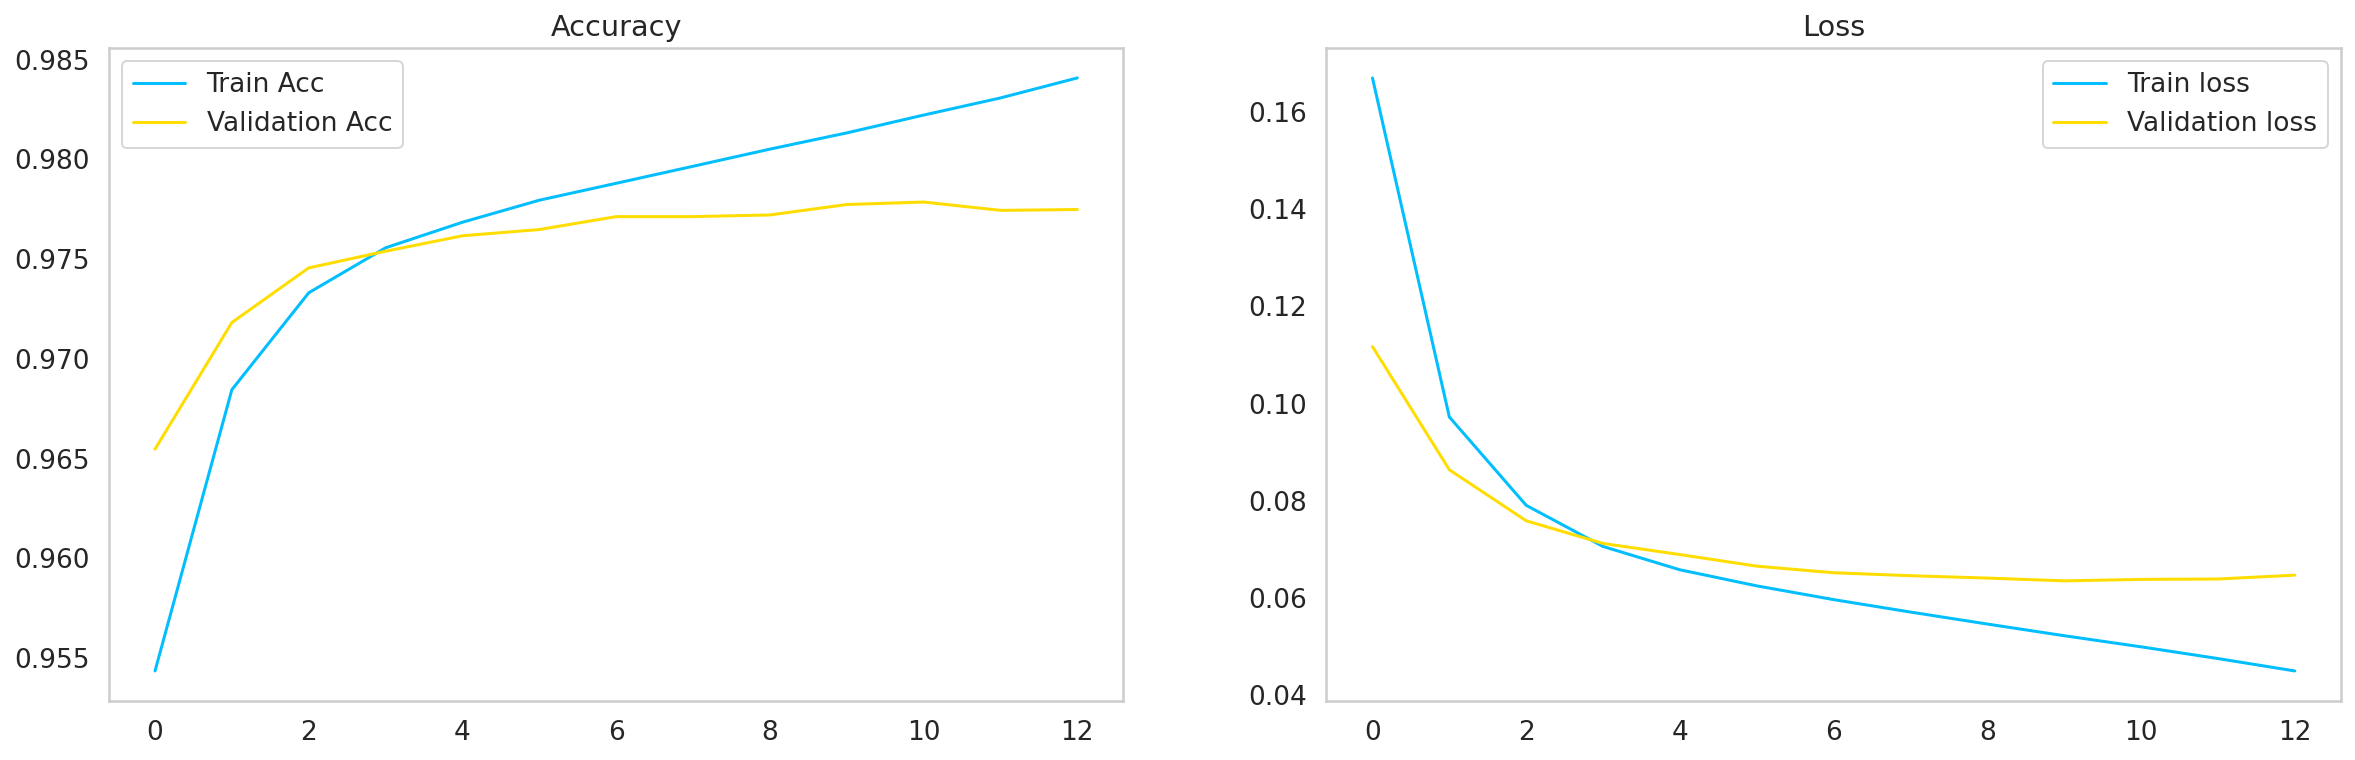

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

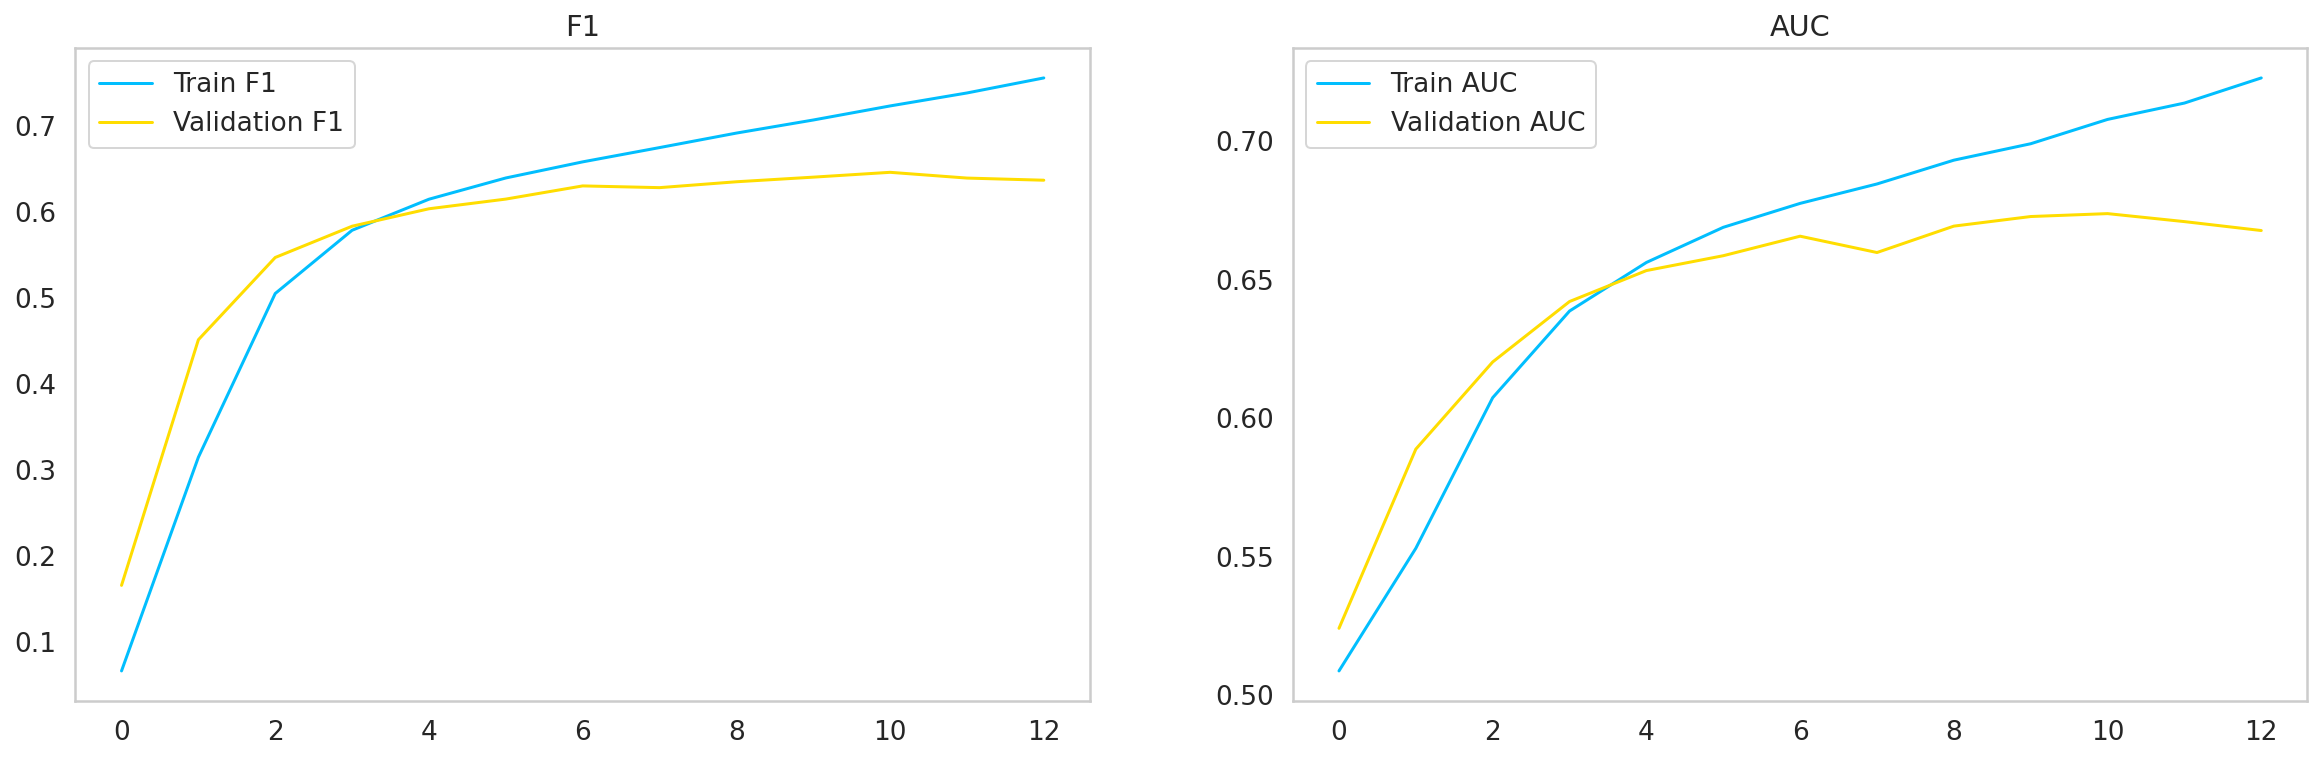

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_f1, label='Train F1')
plt.plot(epoch_vl_f1, label='Validation F1')
plt.title("F1")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_auc, label='Train AUC')
plt.plot(epoch_vl_auc, label='Validation AUC')
plt.title("AUC")
plt.legend()
plt.grid()

plt.show()